In [9]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [10]:
from jax.config import config
config.update("jax_debug_nans", True)

In [11]:
class GaussianDiffusion:
    def __init__(self, key, var_schedule):
        self.key = random.PRNGKey(key)
        self.var_schedule = var_schedule
        self.timesteps, = var_schedule.shape
        pass

    def diffuse(self, x_init, timesteps, debug=True, debug_all=True):
        assert timesteps <= self.timesteps, f"{timesteps} exceeds max {self.timesteps}"
        n = x_init.shape[0]
        x = x_init
        if debug_all:
            states = []

        for t in jnp.arange(0, timesteps):
            if debug:
                print(x)
            if debug_all:
                states.append(x)

            key, subkey = random.split(self.key)

            beta_t = self.var_schedule[t]
            mean = jnp.dot(jnp.sqrt(1 - beta_t), x)
            cov = jnp.dot(beta_t, jnp.eye(n))
            gaussian_noise = random.multivariate_normal(subkey, mean, cov)
            self.key = key
            
            x += gaussian_noise

        if debug:
            print(x)
        if debug_all:
            states.append(x)
            return states
            
        return x


In [14]:
# var_schedule = jnp.array([0.5, 0.2, 0.1])
var_schedule = jnp.array([0.1, 0.2, 0.5])
diffusion_chain = GaussianDiffusion(0, var_schedule)
# x_init = jnp.array([1.0, 0.0, 0.0])
x_init = jnp.eye(3)
states = diffusion_chain.diffuse(x_init, 3, debug=False)

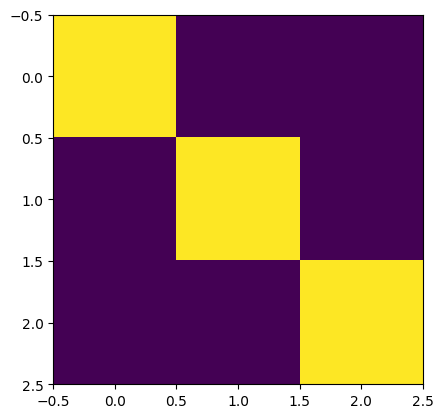

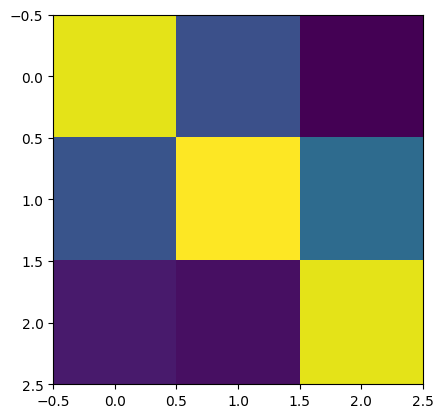

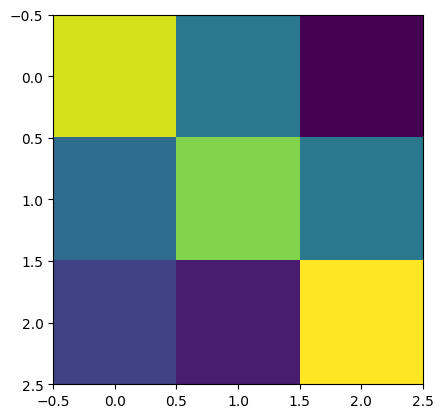

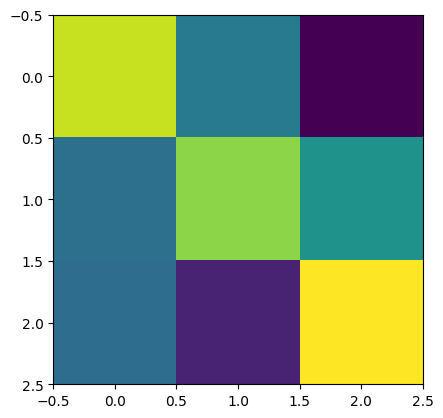

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

for state in states:
    plt.imshow(state)
    # print(state)
    plt.show()

In [ ]:
# from paper
def normal_kl(mean1, logvar1, mean2, logvar2):
  """
  KL divergence between normal distributions parameterized by mean and log-variance.
  """
  return 0.5 * (-1.0 + logvar2 - logvar1 + tf.exp(logvar1 - logvar2)
                + tf.squared_difference(mean1, mean2) * tf.exp(-logvar2))


def _warmup_beta(beta_start, beta_end, num_diffusion_timesteps, warmup_frac):
  betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
  warmup_time = int(num_diffusion_timesteps * warmup_frac)
  betas[:warmup_time] = np.linspace(beta_start, beta_end, warmup_time, dtype=np.float64)
  return betas


def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
  if beta_schedule == 'quad':
    betas = np.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps, dtype=np.float64) ** 2
  elif beta_schedule == 'linear':
    betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
  elif beta_schedule == 'warmup10':
    betas = _warmup_beta(beta_start, beta_end, num_diffusion_timesteps, 0.1)
  elif beta_schedule == 'warmup50':
    betas = _warmup_beta(beta_start, beta_end, num_diffusion_timesteps, 0.5)
  elif beta_schedule == 'const':
    betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
  elif beta_schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
    betas = 1. / np.linspace(num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64)
  else:
    raise NotImplementedError(beta_schedule)
  assert betas.shape == (num_diffusion_timesteps,)
  return betas


def noise_like(shape, noise_fn=tf.random_normal, repeat=False, dtype=tf.float32):
  repeat_noise = lambda: tf.repeat(noise_fn(shape=(1, *shape[1:]), dtype=dtype), repeats=shape[0], axis=0)
  noise = lambda: noise_fn(shape=shape, dtype=dtype)
  return repeat_noise() if repeat else noise()

In [ ]:
# from paper gaussian diffusion class
class GaussianDiffusion:
  """
  Contains utilities for the diffusion model.
  """

  def __init__(self, *, betas, loss_type, tf_dtype=tf.float32):
    self.loss_type = loss_type

    assert isinstance(betas, np.ndarray)
    self.np_betas = betas = betas.astype(np.float64)  # computations here in float64 for accuracy
    assert (betas > 0).all() and (betas <= 1).all()
    timesteps, = betas.shape
    self.num_timesteps = int(timesteps)

    alphas = 1. - betas
    alphas_cumprod = np.cumprod(alphas, axis=0)
    alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])
    assert alphas_cumprod_prev.shape == (timesteps,)

    self.betas = tf.constant(betas, dtype=tf_dtype)
    self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf_dtype)
    self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf_dtype)

    # calculations for diffusion q(x_t | x_{t-1}) and others
    self.sqrt_alphas_cumprod = tf.constant(np.sqrt(alphas_cumprod), dtype=tf_dtype)
    self.sqrt_one_minus_alphas_cumprod = tf.constant(np.sqrt(1. - alphas_cumprod), dtype=tf_dtype)
    self.log_one_minus_alphas_cumprod = tf.constant(np.log(1. - alphas_cumprod), dtype=tf_dtype)
    self.sqrt_recip_alphas_cumprod = tf.constant(np.sqrt(1. / alphas_cumprod), dtype=tf_dtype)
    self.sqrt_recipm1_alphas_cumprod = tf.constant(np.sqrt(1. / alphas_cumprod - 1), dtype=tf_dtype)

    # calculations for posterior q(x_{t-1} | x_t, x_0)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
    # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
    self.posterior_variance = tf.constant(posterior_variance, dtype=tf_dtype)
    # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
    self.posterior_log_variance_clipped = tf.constant(np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf_dtype)
    self.posterior_mean_coef1 = tf.constant(
      betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod), dtype=tf_dtype)
    self.posterior_mean_coef2 = tf.constant(
      (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod), dtype=tf_dtype)

  @staticmethod
  def _extract(a, t, x_shape):
    """
    Extract some coefficients at specified timesteps,
    then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
    """
    bs, = t.shape
    assert x_shape[0] == bs
    out = tf.gather(a, t)
    assert out.shape == [bs]
    return tf.reshape(out, [bs] + ((len(x_shape) - 1) * [1]))

  def q_mean_variance(self, x_start, t):
    mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
    variance = self._extract(1. - self.alphas_cumprod, t, x_start.shape)
    log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
    return mean, variance, log_variance

  def q_sample(self, x_start, t, noise=None):
    """
    Diffuse the data (t == 0 means diffused for 1 step)
    """
    if noise is None:
      noise = tf.random_normal(shape=x_start.shape)
    assert noise.shape == x_start.shape
    return (
        self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
        self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
    )

  def predict_start_from_noise(self, x_t, t, noise):
    assert x_t.shape == noise.shape
    return (
        self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
        self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
    )

  def q_posterior(self, x_start, x_t, t):
    """
    Compute the mean and variance of the diffusion posterior q(x_{t-1} | x_t, x_0)
    """
    assert x_start.shape == x_t.shape
    posterior_mean = (
        self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
        self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
    )
    posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
    posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
    assert (posterior_mean.shape[0] == posterior_variance.shape[0] == posterior_log_variance_clipped.shape[0] ==
            x_start.shape[0])
    return posterior_mean, posterior_variance, posterior_log_variance_clipped

  def p_losses(self, denoise_fn, x_start, t, noise=None):
    """
    Training loss calculation
    """
    B, H, W, C = x_start.shape.as_list()
    assert t.shape == [B]

    if noise is None:
      noise = tf.random_normal(shape=x_start.shape, dtype=x_start.dtype)
    assert noise.shape == x_start.shape and noise.dtype == x_start.dtype
    x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
    x_recon = denoise_fn(x_noisy, t)
    assert x_noisy.shape == x_start.shape
    assert x_recon.shape[:3] == [B, H, W] and len(x_recon.shape) == 4

    if self.loss_type == 'noisepred':
      # predict the noise instead of x_start. seems to be weighted naturally like SNR
      assert x_recon.shape == x_start.shape
      losses = nn.meanflat(tf.squared_difference(noise, x_recon))
    else:
      raise NotImplementedError(self.loss_type)

    assert losses.shape == [B]
    return losses

  def p_mean_variance(self, denoise_fn, *, x, t, clip_denoised: bool):
    if self.loss_type == 'noisepred':
      x_recon = self.predict_start_from_noise(x, t=t, noise=denoise_fn(x, t))
    else:
      raise NotImplementedError(self.loss_type)

    if clip_denoised:
      x_recon = tf.clip_by_value(x_recon, -1., 1.)

    model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
    assert model_mean.shape == x_recon.shape == x.shape
    assert posterior_variance.shape == posterior_log_variance.shape == [x.shape[0], 1, 1, 1]
    return model_mean, posterior_variance, posterior_log_variance

  def p_sample(self, denoise_fn, *, x, t, noise_fn, clip_denoised=True, repeat_noise=False):
    """
    Sample from the model
    """
    model_mean, _, model_log_variance = self.p_mean_variance(denoise_fn, x=x, t=t, clip_denoised=clip_denoised)
    noise = noise_like(x.shape, noise_fn, repeat_noise)
    assert noise.shape == x.shape
    # no noise when t == 0
    nonzero_mask = tf.reshape(1 - tf.cast(tf.equal(t, 0), tf.float32), [x.shape[0]] + [1] * (len(x.shape) - 1))
    return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

  def p_sample_loop(self, denoise_fn, *, shape, noise_fn=tf.random_normal):
    """
    Generate samples
    """
    i_0 = tf.constant(self.num_timesteps - 1, dtype=tf.int32)
    assert isinstance(shape, (tuple, list))
    img_0 = noise_fn(shape=shape, dtype=tf.float32)
    _, img_final = tf.while_loop(
      cond=lambda i_, _: tf.greater_equal(i_, 0),
      body=lambda i_, img_: [
        i_ - 1,
        self.p_sample(denoise_fn=denoise_fn, x=img_, t=tf.fill([shape[0]], i_), noise_fn=noise_fn)
      ],
      loop_vars=[i_0, img_0],
      shape_invariants=[i_0.shape, img_0.shape],
      back_prop=False
    )
    assert img_final.shape == shape
    return img_final

  def p_sample_loop_trajectory(self, denoise_fn, *, shape, noise_fn=tf.random_normal, repeat_noise_steps=-1):
    """
    Generate samples, returning intermediate images
    Useful for visualizing how denoised images evolve over time
    Args:
      repeat_noise_steps (int): Number of denoising timesteps in which the same noise
        is used across the batch. If >= 0, the initial noise is the same for all batch elemements.
    """
    i_0 = tf.constant(self.num_timesteps - 1, dtype=tf.int32)
    assert isinstance(shape, (tuple, list))
    img_0 = noise_like(shape, noise_fn, repeat_noise_steps >= 0)
    times = tf.Variable([i_0])
    imgs = tf.Variable([img_0])
    # Steps with repeated noise
    times, imgs = tf.while_loop(
      cond=lambda times_, _: tf.less_equal(self.num_timesteps - times_[-1], repeat_noise_steps),
      body=lambda times_, imgs_: [
        tf.concat([times_, [times_[-1] - 1]], 0),
        tf.concat([imgs_, [self.p_sample(denoise_fn=denoise_fn,
                                         x=imgs_[-1],
                                         t=tf.fill([shape[0]], times_[-1]),
                                         noise_fn=noise_fn,
                                         repeat_noise=True)]], 0)
      ],
      loop_vars=[times, imgs],
      shape_invariants=[tf.TensorShape([None, *i_0.shape]),
                        tf.TensorShape([None, *img_0.shape])],
      back_prop=False
    )
    # Steps with different noise for each batch element
    times, imgs = tf.while_loop(
      cond=lambda times_, _: tf.greater_equal(times_[-1], 0),
      body=lambda times_, imgs_: [
        tf.concat([times_, [times_[-1] - 1]], 0),
        tf.concat([imgs_, [self.p_sample(denoise_fn=denoise_fn,
                                         x=imgs_[-1],
                                         t=tf.fill([shape[0]], times_[-1]),
                                         noise_fn=noise_fn,
                                         repeat_noise=False)]], 0)
      ],
      loop_vars=[times, imgs],
      shape_invariants=[tf.TensorShape([None, *i_0.shape]),
                        tf.TensorShape([None, *img_0.shape])],
      back_prop=False
    )
    assert imgs[-1].shape == shape
    return times, imgs

  def interpolate(self, denoise_fn, *, shape, noise_fn=tf.random_normal):
    """
    Interpolate between images.
    t == 0 means diffuse images for 1 timestep before mixing.
    """
    assert isinstance(shape, (tuple, list))

    # Placeholders for real samples to interpolate
    x1 = tf.placeholder(tf.float32, shape)
    x2 = tf.placeholder(tf.float32, shape)
    # lam == 0.5 averages diffused images.
    lam = tf.placeholder(tf.float32, shape=())
    t = tf.placeholder(tf.int32, shape=())

    # Add noise via forward diffusion
    # TODO: use the same noise for both endpoints?
    # t_batched = tf.constant([t] * x1.shape[0], dtype=tf.int32)
    t_batched = tf.stack([t] * x1.shape[0])
    xt1 = self.q_sample(x1, t=t_batched)
    xt2 = self.q_sample(x2, t=t_batched)

    # Mix latents
    # Linear interpolation
    xt_interp = (1 - lam) * xt1 + lam * xt2
    # Constant variance interpolation
    # xt_interp = tf.sqrt(1 - lam * lam) * xt1 + lam * xt2

    # Reverse diffusion (similar to self.p_sample_loop)
    # t = tf.constant(t, dtype=tf.int32)
    _, x_interp = tf.while_loop(
      cond=lambda i_, _: tf.greater_equal(i_, 0),
      body=lambda i_, img_: [
        i_ - 1,
        self.p_sample(denoise_fn=denoise_fn, x=img_, t=tf.fill([shape[0]], i_), noise_fn=noise_fn)
      ],
      loop_vars=[t, xt_interp],
      shape_invariants=[t.shape, xt_interp.shape],
      back_prop=False
    )
    assert x_interp.shape == shape

    return x1, x2, lam, x_interp, t